## 1 Import packages

In [ ]:
from openpiv import tools, pyprocess, validation, filters, scaling, preprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import importlib_resources
import pathlib
import os
import glob
from openpiv.tools import imread
from matplotlib.animation import FFMpegWriter
from IPython.display import Video, display
from skimage.draw import polygon
from skimage.draw import disk
from skimage.io import imsave
from skimage.util import invert
import imageio.v3 as iio
from skimage.draw import ellipse
import re
from scipy.stats import mode  

## 2 Generate PIV Video

### 2.1 Define input and output directories

In [ ]:
# Define base path and file names
base_path = pathlib.Path('/Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_') # insert input directory

def natural_sort_key(file):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', file)]

image_files = sorted(
    [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith('.tif') and not f.startswith('._')],
    key=natural_sort_key
)

# Define output directory and ensure it exists
output_dir = "/Volumes/2TB/PIV_video/AHD1/videos"
os.makedirs(output_dir, exist_ok=True)  # Create folder if it doesn’t exist
output_video = os.path.join(output_dir, "piv_ADH1_250103.T012P05_Z1_mGC.mp4")

### 2.2 Initialisation

In [ ]:
# Define video writer
metadata = dict(title="PIV Video", artist="Matplotlib")

writer = FFMpegWriter(
    fps=1,  # Adjust frames per second
    metadata=metadata,
    bitrate=10000,  # Higher bitrate for better quality
    extra_args=["-crf", "15", "-preset", "fast"]  # High-quality encoding
)

# Define pixel-to-micrometer conversion factor
px_to_um = 163.98 / 1055  # 1 pixel = 0.1555 um

# PIV parameters
winsize = 50
searchsize = 60
overlap = 40
dt = 1 #sec

# Initialize figure and colormap
fig, ax = plt.subplots(figsize=(10, 10))

# Initialize dummy quiver plot for color bar (without fixed vmin/vmax)
cmap = plt.cm.viridis  # Choose a colormap (e.g., 'viridis', 'jet', 'plasma')
norm = plt.Normalize()  # Allow dynamic range

# Create a dummy quiver for color bar
dummy_quiver = ax.quiver([], [], [], [], [], cmap=cmap, norm=norm)
cbar = fig.colorbar(dummy_quiver, ax=ax)
cbar.set_label("Velocity Magnitude (px/s)", fontsize=12)

# Preload images before entering the loop
frames = [tools.imread(f) for f in image_files]

### 2.3 Perform PIV

In [ ]:
# Create video writer context
with writer.saving(fig, output_video, dpi=300):
    for i in range(len(image_files) - 1):
        ########################################################################
        #                             Input Images                             #
        ########################################################################
        print(f"Processing Frame {i}: {image_files[i]}")
        # Read consecutive frames
        frame_a = frames[i]
        frame_b = frames[i + 1]

        # Perform PIV
        u, v, sig2noise = pyprocess.extended_search_area_piv(
            frame_a, frame_b,
            window_size=winsize,
            overlap=overlap,
            dt=dt,
            search_area_size=searchsize,
            sig2noise_method="peak2peak",
        )

        # Get grid coordinates (convert to micrometers)
        x, y = pyprocess.get_coordinates(
            image_size=frame_a.shape,
            search_area_size=searchsize,
            overlap=overlap,
        )

        x = x * px_to_um  # Convert x-coordinates to um
        y = y * px_to_um  # Convert y-coordinates to um

        # Apply signal-to-noise mask
        invalid_mask = validation.sig2noise_val(
            sig2noise,
            threshold=1.0
        )

        # Remove outliers
        u, v = filters.replace_outliers(
            u, v,
            invalid_mask,
            method='distance',
            max_iter=10,
            kernel_size=2,
        )

        ########################################################################
        #                       Remove global displacement                     #
        ########################################################################

        # Compute global displacement (average of all valid vectors)
        mean_u = np.mean(u[~invalid_mask]) 
        mean_v = np.mean(v[~invalid_mask])

        # Remove global displacement
        u -= mean_u
        v -= mean_v

        # Convert velocities from px/s to um/s
        u = u * px_to_um
        v = v * px_to_um
        
        ########################################################################
        #                                Masking                               #
        ########################################################################

        #####################
        #   Circular Mask   #
        #####################
        # Define mask parameters
        center = (frame_a.shape[1]// 2, frame_a.shape[0] // 2)  
        radius = min(frame_a.shape[0], frame_a.shape[1]) //4
        
        # print(f"Center: {center}, Radius: {radius}")

        # Create a circular mask (Still in pixel units)
        mask = np.zeros(frame_a.shape, dtype=bool)
        rr, cc = disk(center, radius, shape=frame_a.shape)
        mask[rr, cc] = True

        # Invert mask
        inverted_mask = np.logical_not(mask)

        # Convert mask to match PIV grid resolution
        grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)
        
        #####################
        #  Elliptical Mask  #
        #####################
        # # Define mask parameters
        # center = (frame_a.shape[1] // 2, frame_a.shape[0] // 2.2) 
        # radius_x = frame_a.shape[1] // 2.4  # Horizontal radius
        # radius_y = frame_a.shape[0] // 2.5  # Vertical radius

        # # Create an elliptical mask
        # mask = np.zeros(frame_a.shape, dtype=bool)
        # rr, cc = ellipse(center[1], center[0], radius_y, radius_x, shape=frame_a.shape)
        # mask[rr, cc] = True  # Set the mask area to True

        # # Invert mask
        # inverted_mask = np.logical_not(mask)

        # # Convert mask to match PIV grid resolution
        # grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)
        
        ########################
        # Donut (Annular) Mask #
        ########################
        
        # # Define mask parameters
        # center = (frame_a.shape[1] // 2, frame_a.shape[0] // 2)  
        # outer_radius = min(frame_a.shape[0], frame_a.shape[1]) // 3  # Outer radius
        # inner_radius = outer_radius // 2  # Inner radius (adjust as needed)

        # # Create an empty mask
        # mask = np.zeros(frame_a.shape, dtype=bool)

        # # Create the outer circle mask
        # rr_outer, cc_outer = disk(center, outer_radius, shape=frame_a.shape)
        # mask[rr_outer, cc_outer] = True  # Mark outer region as True

        # # Create the inner circle mask (to be removed)
        # rr_inner, cc_inner = disk(center, inner_radius, shape=frame_a.shape)
        # mask[rr_inner, cc_inner] = False  # Remove inner region

        # # Invert mask
        # inverted_mask = np.logical_not(mask)

        # # Convert mask to match PIV grid resolution
        # grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)

        #############################################
        # Velocity Threshold Mask (Exclude Top 25%) #
        #############################################
        # Compute velocity magnitude in um/s
        velocity_magnitude = np.sqrt(u**2 + v**2)

        # Find the 75th percentile (top 25% threshold)
        velocity_threshold = np.percentile(velocity_magnitude, 75)

        # Create a mask for velocities greater than this threshold
        velocity_mask = velocity_magnitude > velocity_threshold

        # Combine masks: SNR mask + circular mask + velocity threshold mask
        combined_mask = grid_mask | invalid_mask | velocity_mask

        # Apply the final mask to velocity vectors
        masked_u = np.ma.masked_array(u, mask=combined_mask)
        masked_v = np.ma.masked_array(v, mask=combined_mask)

        ########################################################################
        #                        Plot and Save Frames                          #
        ########################################################################
        ax.clear()  

        # Define micrometer-based extent for the original image
        height, width = frame_b.shape
        extent = [0, width * px_to_um, height * px_to_um, 0]  # [Xmin, Xmax, Ymax, Ymin]

        # Plot the original image with updated axes
        ax.imshow(frame_b, alpha=1, cmap="gray", origin="upper", extent=extent)

        # Compute velocity magnitude for color mapping
        velocity_magnitude = np.sqrt(masked_u**2 + masked_v**2)

        # Dynamically update vmin and vmax for each frame
        norm.vmin = np.nanmin(velocity_magnitude)
        norm.vmax = np.nanmax(velocity_magnitude)

        # Plot velocity vectors with colormap
        quiver = ax.quiver(x, y, masked_u, -masked_v, velocity_magnitude, 
                            alpha=1, cmap=plt.cm.plasma, scale=7, width=0.007, norm=norm)

        # Update color bar scale dynamically
        cbar.update_normal(quiver)

        # Change color bar label
        cbar.set_label("Velocity Magnitude (um/5min)", fontsize=12)
    
        # Extract base filename from output video file
        video_base_name = os.path.basename(output_video).split(".mp4")[0]

        # Add the video name to the plot title
        ax.set_title(f"{video_base_name}, Frame {i + 1}", fontsize=14)
        ax.set_xlabel("X (pixels)")
        ax.set_ylabel("Y (pixels)")
        
        # Save frame to video
        writer.grab_frame()

### 2.4 Display Video

In [ ]:
print(f"Video saved as {output_video}")

# Inline display of video (for Jupyter Notebooks)
from IPython.display import Video, display
display(Video(output_video, embed=True))

## 3 Generata velocity histogram

### 3.1 Define input and output directories

In [36]:
# Base directory containing images
base_path = pathlib.Path('/Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_')

def natural_sort_key(file):
    """Helper function to sort filenames naturally."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', file)]

# Get and sort image files
image_files = sorted(
    [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith('.tif') and not f.startswith('._')],
    key=natural_sort_key
)

# Output directory for histogram and velocity data
output_dir = "/Volumes/2TB/PIV_video/AHD1/250103/250103_histogram"
os.makedirs(output_dir, exist_ok=True)  # Ensure the folder exists

output_dir_v = "/Volumes/2TB/PIV_video/AHD1/250103/250103_vdata"
os.makedirs(output_dir_v, exist_ok=True)  # Ensure the folder exists

# File paths for output
histogram_filename = os.path.join(output_dir, "vhis_ADH1_250103.T012P05_Z1_mGC.png")
velocity_filename = os.path.join(output_dir_v, "v_ADH1_250103.T012P05_Z1_mGC.txt")  # Save u, v velocities

### 3.2 Initialisation

In [37]:
# Pixel-to-micrometer conversion factor
px_to_um = 163.98 / 1055  

# PIV parameters
winsize = 50
searchsize = 60
overlap = 40
dt = 1  

# Preload images before entering the loop
frames = [tools.imread(f) for f in image_files]

all_velocities = []  # Store velocity magnitudes
all_velocity_data = []  # Store (u, v) velocity pairs

### 3.3 Perform PIV

In [ ]:
for i in range(len(image_files) - 1):
    print(f"Processing Frame {i}: {image_files[i]}")
    
    frame_a = frames[i]
    frame_b = frames[i + 1]

    # Perform PIV
    u, v, sig2noise = pyprocess.extended_search_area_piv(
        frame_a, frame_b,
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method="peak2peak",
    )

    # Get grid coordinates
    x, y = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )

    # Convert to micrometer scale
    x = x * px_to_um  
    y = y * px_to_um  

    # Apply signal-to-noise mask
    invalid_mask = validation.sig2noise_val(sig2noise, threshold=1.0)

    # Remove outliers
    u, v = filters.replace_outliers(u, v, invalid_mask, method='distance', max_iter=10, kernel_size=2)

    ########################################################################
    #                       Remove global displacement                     #
    ########################################################################

    # Remove Global Displacement
    mean_u = np.mean(u[~invalid_mask])  
    mean_v = np.mean(v[~invalid_mask])
    u -= mean_u
    v -= mean_v

    # Convert velocities to um/s
    u = u * px_to_um
    v = v * px_to_um

    ########################################################################
    #                                Masking                               #
    ########################################################################
    

    #####################
    #   Circular Mask   #
    #####################
    # Define mask parameters
    center = (frame_a.shape[1]// 2, frame_a.shape[0] // 2)  
    radius = min(frame_a.shape[0], frame_a.shape[1]) //3
    
    # print(f"Center: {center}, Radius: {radius}")

    # Create a circular mask (Still in pixel units)
    mask = np.zeros(frame_a.shape, dtype=bool)
    rr, cc = disk(center, radius, shape=frame_a.shape)
    mask[rr, cc] = True

    # Invert mask
    inverted_mask = np.logical_not(mask)

    # Convert mask to match PIV grid resolution
    grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)
    
    #####################
    #  Elliptical Mask  #
    #####################
    # # Define mask parameters
    # center = (frame_a.shape[1] // 2, frame_a.shape[0] // 2.2) 
    # radius_x = frame_a.shape[1] // 2.4  # Horizontal radius
    # radius_y = frame_a.shape[0] // 2.5  # Vertical radius

    # # Create an elliptical mask
    # mask = np.zeros(frame_a.shape, dtype=bool)
    # rr, cc = ellipse(center[1], center[0], radius_y, radius_x, shape=frame_a.shape)
    # mask[rr, cc] = True  # Set the mask area to True

    # # Invert mask
    # inverted_mask = np.logical_not(mask)

    # # Convert mask to match PIV grid resolution
    # grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)
    
    ########################
    # Donut (Annular) Mask #
    ########################
    
    # # Define mask parameters
    # center = (frame_a.shape[1] // 2, frame_a.shape[0] // 2)  
    # outer_radius = min(frame_a.shape[0], frame_a.shape[1]) // 3  # Outer radius
    # inner_radius = outer_radius // 2  # Inner radius (adjust as needed)

    # # Create an empty mask
    # mask = np.zeros(frame_a.shape, dtype=bool)

    # # Create the outer circle mask
    # rr_outer, cc_outer = disk(center, outer_radius, shape=frame_a.shape)
    # mask[rr_outer, cc_outer] = True  # Mark outer region as True

    # # Create the inner circle mask (to be removed)
    # rr_inner, cc_inner = disk(center, inner_radius, shape=frame_a.shape)
    # mask[rr_inner, cc_inner] = False  # Remove inner region

    # # Invert mask
    # inverted_mask = np.logical_not(mask)

    # # Convert mask to match PIV grid resolution
    # grid_mask = preprocess.prepare_mask_on_grid(x / px_to_um, y / px_to_um, inverted_mask)
    
    #############################################
    # Velocity Threshold Mask (Exclude Top 25%) #
    #############################################
    velocity_magnitude = np.sqrt(u**2 + v**2)
    velocity_threshold = np.percentile(velocity_magnitude, 75)
    velocity_mask = velocity_magnitude > velocity_threshold

    # Combine all masks
    combined_mask = grid_mask | invalid_mask | velocity_mask

    # Apply masks
    masked_u = np.ma.masked_array(u, mask=combined_mask)
    masked_v = np.ma.masked_array(v, mask=combined_mask)
    
    # Store valid velocity magnitudes
    if i not in [6, 11]:  # Exclude specific frames (frames with rotations)
        all_velocities.extend(velocity_magnitude[~combined_mask].flatten())

    # Store valid (u, v) values for saving
    valid_u = masked_u[~masked_u.mask].flatten()
    valid_v = masked_v[~masked_v.mask].flatten()
    all_velocity_data.extend(zip(valid_u, valid_v))

Processing Frame 0: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.Group1.A1.T012P05_crop1_HT3D_2_Z1.tif
Processing Frame 1: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.Group1.A1.T012P05_crop1_HT3D_3_Z1.tif
Processing Frame 2: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.Group1.A1.T012P05_crop1_HT3D_4_Z1.tif
Processing Frame 3: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.Group1.A1.T012P05_crop1_HT3D_5_Z1.tif
Processing Frame 4: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.Group1.A1.T012P05_crop1_HT3D_6_Z1.tif
Processing Frame 5: /Volumes/2TB/PIV_video/AHD1/250103/P05/250103.190652.ADH1.012.Group1.A1.T012P05/mid/B15000_/250103.190652.ADH1.012.

### 3.4 Save velocity data into a txt file

In [39]:
# Save (u, v) velocities to a text file
np.savetxt(velocity_filename, all_velocity_data, fmt="%.6f", delimiter="\t", header="u_velocity (um/5m)\tv_velocity (um/5m)")

### 3.5 Customise and plot histogram

Histogram saved to /Volumes/2TB/PIV_video/AHD1/250103/250103_histogram/vhis_ADH1_250103.T012P05_Z1_mGC.png


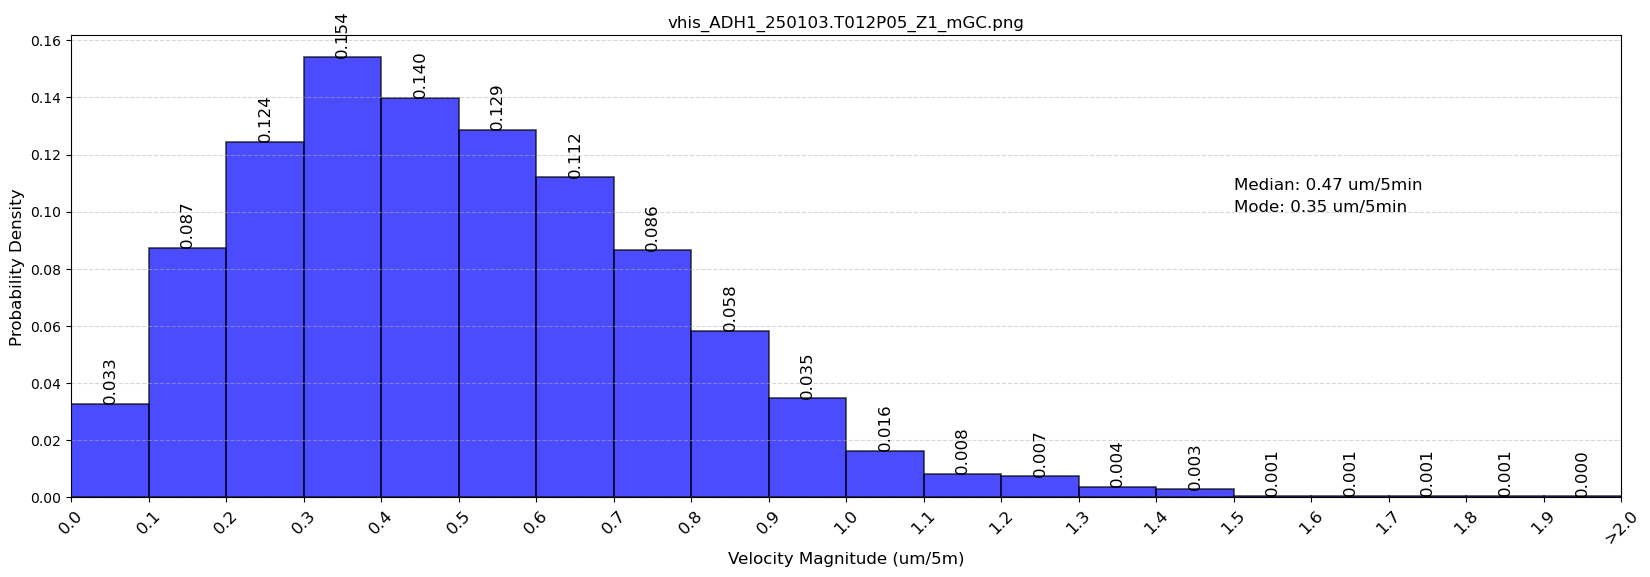

In [40]:
########################################################################
#                        Histogram Configuration                       #
########################################################################
plt.figure(figsize=(20, 6))
# Cap velocities > 2.0 to 2.0
all_velocities = np.array(all_velocities)
all_velocities[all_velocities > 2.0] = 2.0  

# Define bin edges
bin_edges = np.arange(0, 2.0 + 0.1, 0.1)  

# Calculate histogram
counts, bins, patches = plt.hist(
    all_velocities, bins=bin_edges, color="blue", alpha=0.7, edgecolor="black", linewidth=1.2
)

# Probability density
prob_density = counts / len(all_velocities)

# Clear figure and re-plot bar chart
plt.clf()
plt.bar(bin_edges[:-1], prob_density, width=np.diff(bin_edges), align="edge", color="blue", alpha=0.7, edgecolor="black", linewidth=1.2)

# Annotate bin probabilities
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
for pd, bin_center in zip(prob_density, bin_centers):
    plt.text(bin_center, pd, f"{pd:.3f}", ha="center", va="bottom", fontsize=12, rotation=90)

########################################################################
#                          Calculate statistics                        #
########################################################################

non_outlier_velocities = all_velocities[all_velocities <= 2.0]  # Ensure only values ≤ 2.0 are considered
median_velocity = np.median(non_outlier_velocities)

# Determine mode (most frequent bin center)
mode_bin_index = np.argmax(counts)
mode_velocity = bin_centers[mode_bin_index]

########################################################################
#                            Plot Formatting                           #
########################################################################

# X-Axis Formatting
plt.xlim(0, 2.0)
tick_values = np.arange(0, 2.0 + 0.1, 0.1)
tick_labels = [f"{tick:.1f}" for tick in tick_values]
tick_labels[-1] = ">2.0"
plt.xticks(tick_values, tick_labels, rotation=45, fontsize=12)

# Labels and Title
plt.xlabel("Velocity Magnitude (um/5m)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)

# Display Median and Mode
plt.text(1.5, max(prob_density) * 0.7, f"Median: {median_velocity:.2f} um/5min", fontsize=12, color="black")
plt.text(1.5, max(prob_density) * 0.65, f"Mode: {mode_velocity:.2f} um/5min", fontsize=12, color="black")

# Grid and Title
histogram_base_name = os.path.basename(histogram_filename).split(".mp4")[0]
plt.title(f"{histogram_base_name}", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.5)

# Save Histogram
plt.savefig(histogram_filename, dpi=300, bbox_inches='tight')
print(f"Histogram saved to {histogram_filename}")

# Show Plot
plt.show()
